### Model Evaluation

Model evaluation is a critical task in data science. This is one of the few measures business stakeholders are interested in. Model performance heavily influences business impact of a data science project. Therefore, it is important to take some time apart in an independent task in the process model. 

So how are models evaluated? In supervised machine learning this is relatively straightforward since you can always create a ground truth and compare your results against ground truth.

So, we are either splitting data into training-, test- and validation-sets to assess model performance on the test set or we use cross validation. This all is explained in the following coursera course https://www.coursera.org/learn/advanced-machine-learning-signal-processing/ Week 2.

In case we know what data set we can use as ground truth in supervised learning (classification and regression) we need to define a different measure for evaluation than in unsupervised learning (clustering). Since it depends on the type of model we create, the following none exhaustive lists can be used as a starting point for further research:

#### Classification:

- Confusion Matrix

- Accuracy

- Precision

- Recall

- Specificity

- True positive rate

- True negative rate

- False positive rate

- False negative rate

- F1-score

- Gain and Lift

- Kolomogorov Smirnov

- Area Under ROC

- Gini Coefficient

- Concordant – Discordant ratio

#### Regression:

- Root Mean Squared Error (RMSE)

- Mean Squared Error

- Mean Absolute Error (MAE)

- R-Squared

- Relative Squared Error

- Relative Absolute Error

- Sum of Differences

- ACF plot of residuals

- Histogram of residuals

- Residual plots against predictors

- Residual plots against fitted values

Clustering:

- Adjusted Rand index

- Mutual Information

- Homogeneity completeness

- V-measure

- Fowlkes-Mallows

- Silhouette Coefficient Calinski-Harabaz¶

References:

http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

Please choose at least one appropriate model performance measure, justify why you’ve used it and document how iterative changes in the feature creation task influence it.

In [2]:
!pip install tensorflow
!pip install python-mnist
!pip install Pillow
!pip install pyspark
!pip install scikit-learn

     |████████████████████████████████| 65 kB 7.6 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 3.2 MB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 24.8 MB/s eta 0:00:01
  Attempting uninstall: opt-einsum
    Found existing installation: opt-einsum 3.1.0
    Uninstalling opt-einsum-3.1.0:
      Successfully uninstalled opt-einsum-3.1.0
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.0
    Uninstalling Keras-Preprocessing-1.1.0:
      Successfully uninstalled Keras-Preprocessing-1.1.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 20210226132247
    Uninstalling flatbuffers-20210226132247:
      Successfully uninstalled flatbuffers-20210226132247
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.31.0
    Uninstalling grpcio-1.31.0:
      Successfully uninstalled grpcio-1.31.0
     |████████████████████████████████| 212.4 MB 98.2 MB/s eta 0:00:0

In [3]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import image
import tensorflow as tf
import seaborn as sns
from mnist import MNIST
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib.image as mping
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from numpy import asarray
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import backend as K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

tf.__version__

'2.4.1'

In [4]:
PIL.__version__

'8.2.0'

In [5]:
# fire up the spark session
# comment this cell out for a spark server
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [6]:
# enable arrow which lets us transfrom a pandas dataframe into a pyspark dataframe
spark.conf.set("spark.sql.execution.arrow.enabled","true")

## First dataset

#### 60,000 images and 10 classes, each image is 28 x 28 or represented by a 794 element array

In [7]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz?raw=True
!mv train-images-idx3-ubyte.gz?raw=True train-images-idx3-ubyte.gz
!gunzip train-images-idx3-ubyte.gz
!ls -lahr train-images-idx3-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz?raw=True
!mv train-labels-idx1-ubyte.gz?raw=True train-labels-idx1-ubyte.gz
!gunzip train-labels-idx1-ubyte.gz
!ls -lahr train-labels-idx1-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz?raw=True
!mv t10k-images-idx3-ubyte.gz?raw=True t10k-images-idx3-ubyte.gz
!gunzip t10k-images-idx3-ubyte.gz
!ls -lahr t10k-images-idx3-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz?raw=True
!mv t10k-labels-idx1-ubyte.gz?raw=True t10k-labels-idx1-ubyte.gz
!gunzip t10k-labels-idx1-ubyte.gz
!ls -lahr t10k-labels-idx1-ubyte

--2021-07-06 21:06:22--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18165135 (17M)
Saving to: ‘train-images-idx3-ubyte.gz?raw=True’

train-images-idx3-u 100%[===================>]  17.32M  6.12MB/s    in 2.8s    

2021-07-06 21:06:26 (6.12 MB/s) - ‘train-images-idx3-ubyte.gz?raw=True’ saved [18165135/18165135]

-rw-rw---- 1 wsuser watsonstudio 45M Feb  4  2019 train-images-idx3-ubyte
--2021-07-06 21:06:28--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29497 (29K)
Saving to: ‘train-labels-idx1-ubyte.gz?raw=True’

train-labels-id

In [8]:
!mkdir kmnistdata
!cp t10k-images-idx3-ubyte kmnistdata/t10k-images-idx3-ubyte
!cp t10k-labels-idx1-ubyte kmnistdata/t10k-labels-idx1-ubyte
!cp train-images-idx3-ubyte kmnistdata/train-images-idx3-ubyte
!cp train-labels-idx1-ubyte kmnistdata/train-labels-idx1-ubyte
!ls -al kmnistdata

data = MNIST('kmnistdata')
train_images, train_labels = data.load_training()
test_images, test_labels = data.load_testing()

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size = 0.2, random_state=39)

train_images = train_images / 255
val_images = val_images / 255
test_images = test_images / 255

total 53680
drwxrwx--- 2 wsuser watsonstudio     4096 Jul  6 21:06 .
drwxr-x--- 4 wsuser watsonstudio     4096 Jul  6 21:06 ..
-rw-rw---- 1 wsuser watsonstudio  7840016 Jul  6 21:06 t10k-images-idx3-ubyte
-rw-rw---- 1 wsuser watsonstudio    10008 Jul  6 21:06 t10k-labels-idx1-ubyte
-rw-rw---- 1 wsuser watsonstudio 47040016 Jul  6 21:06 train-images-idx3-ubyte
-rw-rw---- 1 wsuser watsonstudio    60008 Jul  6 21:06 train-labels-idx1-ubyte


In [8]:
# model_1 def

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [9]:
# model_1 compile
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# model_1 fit

# began by using 5 epochs here but observed that 
# the validation accuracy is increasing even as we
# stopped training, so consider using more epochs here next

model_1.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(val_images, val_labels))

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.6649 - accuracy: 0.7991 - val_loss: 0.2637 - val_accuracy: 0.9208
Epoch 2/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2289 - accuracy: 0.9338 - val_loss: 0.2120 - val_accuracy: 0.9366
Epoch 3/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1456 - accuracy: 0.9581 - val_loss: 0.1906 - val_accuracy: 0.9412
Epoch 4/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1082 - accuracy: 0.9695 - val_loss: 0.1754 - val_accuracy: 0.9475
Epoch 5/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0808 - accuracy: 0.9780 - val_loss: 0.1725 - val_accuracy: 0.9503
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0598 - accuracy: 0.9837 - val_loss: 0.1786 - val_accuracy: 0.9484
Epoch 7/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0428 - accuracy: 0.9892 - val_loss: 0.1921 - val_accuracy:

In [11]:
score = model_1.evaluate(test_images, test_labels, verbose=0)
print('model_1 test loss:', score[0])
print('model_1 test accuracy', score[1])

model_1 test loss: 0.7422628998756409
model_1 test accuracy 0.8898000121116638


In [12]:
# model_1_1 def

model_1_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [13]:
# model_1_1 compile
model_1_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# model_1_1 fit
model_1_1.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(val_images, val_labels))

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.7687 - accuracy: 0.7554 - val_loss: 0.2541 - val_accuracy: 0.9207
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2931 - accuracy: 0.9109 - val_loss: 0.2060 - val_accuracy: 0.9377
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2234 - accuracy: 0.9312 - val_loss: 0.1899 - val_accuracy: 0.9438
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1942 - accuracy: 0.9399 - val_loss: 0.1709 - val_accuracy: 0.9500
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1658 - accuracy: 0.9476 - val_loss: 0.1640 - val_accuracy: 0.9516
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1471 - accuracy: 0.9530 - val_loss: 0.1629 - val_accuracy: 0.9506
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1370 - accuracy: 0.9550 - val_loss: 0.1594 - val_accuracy:

In [15]:
model_1_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (32, 128)                 100480    
_________________________________________________________________
dropout (Dropout)            (32, 128)                 0         
_________________________________________________________________
dense_3 (Dense)              (32, 128)                 16512     
_________________________________________________________________
dropout_1 (Dropout)          (32, 128)                 0         
_________________________________________________________________
dense_4 (Dense)              (32, 10)                  1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [16]:
score = model_1_1.evaluate(test_images, test_labels, verbose=0)
print('model_1_1 test loss:', score[0])
print('model_1_1 test accuracy', score[1])

model_1_1 test loss: 0.4759407341480255
model_1_1 test accuracy 0.892300009727478


In [17]:
# model_1_2 def

model_1_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [18]:
# model_1_2 compile
model_1_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# model_1_2 fit
model_1_2.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(val_images, val_labels))

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.6492 - accuracy: 0.7954 - val_loss: 0.2544 - val_accuracy: 0.9208
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1985 - accuracy: 0.9398 - val_loss: 0.1897 - val_accuracy: 0.9441
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1380 - accuracy: 0.9580 - val_loss: 0.1827 - val_accuracy: 0.9473
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1004 - accuracy: 0.9685 - val_loss: 0.1801 - val_accuracy: 0.9492
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0796 - accuracy: 0.9746 - val_loss: 0.2108 - val_accuracy: 0.9409
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0682 - accuracy: 0.9793 - val_loss: 0.1901 - val_accuracy: 0.9522
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0528 - accuracy: 0.9840 - val_loss: 0.1893 - val_accuracy:

In [20]:
model_1_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (32, 128)                 100480    
_________________________________________________________________
dense_6 (Dense)              (32, 128)                 16512     
_________________________________________________________________
dense_7 (Dense)              (32, 128)                 16512     
_________________________________________________________________
dense_8 (Dense)              (32, 128)                 16512     
_________________________________________________________________
dense_9 (Dense)              (32, 10)                  1290      
Total params: 151,306
Trainable params: 151,306
Non-trainable params: 0
_________________________________________________________________


In [21]:
score = model_1_2.evaluate(test_images, test_labels, verbose=0)
print('model_1_2 test loss:', score[0])
print('model_1_2 test accuracy', score[1])

model_1_2 test loss: 0.755105197429657
model_1_2 test accuracy 0.8855000138282776


In [22]:
# model_1_3 def

model_1_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [23]:
# model_1_3 compile
model_1_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# model_1_3 fit
model_1_3.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(val_images, val_labels))

Epoch 1/20
1500/1500 [==============================] - 6s 3ms/step - loss: 0.7879 - accuracy: 0.7441 - val_loss: 0.2740 - val_accuracy: 0.9162
Epoch 2/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2543 - accuracy: 0.9245 - val_loss: 0.2046 - val_accuracy: 0.9371
Epoch 3/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1856 - accuracy: 0.9452 - val_loss: 0.1845 - val_accuracy: 0.9461
Epoch 4/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1473 - accuracy: 0.9556 - val_loss: 0.1837 - val_accuracy: 0.9461
Epoch 5/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1192 - accuracy: 0.9650 - val_loss: 0.2088 - val_accuracy: 0.9425
Epoch 6/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1028 - accuracy: 0.9686 - val_loss: 0.1925 - val_accuracy: 0.9503
Epoch 7/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0899 - accuracy: 0.9716 - val_loss: 0.1894 - val_accuracy:

In [25]:
score = model_1_3.evaluate(test_images, test_labels, verbose=0)
print('model_1_3 test loss:', score[0])
print('model_1_3 test accuracy', score[1])

model_1_3 test loss: 0.5735206007957458
model_1_3 test accuracy 0.8925999999046326


In [26]:
# model_1_4 def

model_1_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [27]:
# model_1_4 compile

model_1_4.compile(optimizer=tf.keras.optimizers.Adadelta(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
# model_1_4 fit

model_1_4.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(val_images, val_labels))

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 2.2875 - accuracy: 0.1197 - val_loss: 2.2531 - val_accuracy: 0.2028
Epoch 2/20
1500/1500 [==============================] - 5s 3ms/step - loss: 2.2394 - accuracy: 0.2291 - val_loss: 2.2018 - val_accuracy: 0.2755
Epoch 3/20
1500/1500 [==============================] - 5s 3ms/step - loss: 2.1866 - accuracy: 0.2825 - val_loss: 2.1404 - val_accuracy: 0.3061
Epoch 4/20
1500/1500 [==============================] - 5s 3ms/step - loss: 2.1215 - accuracy: 0.3168 - val_loss: 2.0678 - val_accuracy: 0.3363
Epoch 5/20
1500/1500 [==============================] - 5s 3ms/step - loss: 2.0486 - accuracy: 0.3438 - val_loss: 1.9851 - val_accuracy: 0.3720
Epoch 6/20
1500/1500 [==============================] - 5s 3ms/step - loss: 1.9689 - accuracy: 0.3777 - val_loss: 1.8948 - val_accuracy: 0.4141
Epoch 7/20
1500/1500 [==============================] - 5s 3ms/step - loss: 1.8720 - accuracy: 0.4223 - val_loss: 1.7987 - val_accuracy:

In [29]:
score = model_1_4.evaluate(test_images, test_labels, verbose=0)
print('model_1_4 test loss:', score[0])
print('model_1_4 test accuracy', score[1])

model_1_4 test loss: 1.3908430337905884
model_1_4 test accuracy 0.569100022315979


In [30]:
# model_1_4_1 def (using the dropouts with adadelta)

model_1_4_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [31]:
# model_1_4_1 compile

model_1_4_1.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate = 1.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# model_1_4_1 fit

model_1_4_1.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(val_images, val_labels))

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.7651 - accuracy: 0.7566 - val_loss: 0.2681 - val_accuracy: 0.9169
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3004 - accuracy: 0.9087 - val_loss: 0.2053 - val_accuracy: 0.9390
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2459 - accuracy: 0.9257 - val_loss: 0.1834 - val_accuracy: 0.9461
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1993 - accuracy: 0.9396 - val_loss: 0.1820 - val_accuracy: 0.9464
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1822 - accuracy: 0.9451 - val_loss: 0.1738 - val_accuracy: 0.9496
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1671 - accuracy: 0.9487 - val_loss: 0.1756 - val_accuracy: 0.9494
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1532 - accuracy: 0.9530 - val_loss: 0.1665 - val_accuracy:

In [33]:
score = model_1_4_1.evaluate(test_images, test_labels, verbose=0)
print('model_1_4_1 test loss:', score[0])
print('model_1_4_1 test accuracy', score[1])

model_1_4_1 test loss: 0.5012156367301941
model_1_4_1 test accuracy 0.8932999968528748


In [34]:
# model_1_5 def

model_1_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [35]:
# model_1_5 compile

model_1_5.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
# model_1_5 fit

model_1_5.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(val_images, val_labels))

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 1.6107 - accuracy: 0.4708 - val_loss: 0.5670 - val_accuracy: 0.8272
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5150 - accuracy: 0.8446 - val_loss: 0.3987 - val_accuracy: 0.8789
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3817 - accuracy: 0.8859 - val_loss: 0.3519 - val_accuracy: 0.8922
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3098 - accuracy: 0.9067 - val_loss: 0.2914 - val_accuracy: 0.9107
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2620 - accuracy: 0.9237 - val_loss: 0.2657 - val_accuracy: 0.9185
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2283 - accuracy: 0.9322 - val_loss: 0.2466 - val_accuracy: 0.9245
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1901 - accuracy: 0.9446 - val_loss: 0.2382 - val_accuracy:

In [37]:
score = model_1_5.evaluate(test_images, test_labels, verbose=0)
print('model_1_5 test loss:', score[0])
print('model_1_5 test accuracy', score[1])

model_1_5 test loss: 0.5508348941802979
model_1_5 test accuracy 0.8748999834060669


In [38]:
# model_1_5_1 def

model_1_5_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [39]:
# model_1_5_1 compile

model_1_5_1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# model_1_5_1 fit

model_1_5_1.fit(train_images, train_labels, epochs=20, verbose=1, validation_data=(val_images, val_labels))

Epoch 1/20
1500/1500 [==============================] - 4s 3ms/step - loss: 1.5708 - accuracy: 0.4783 - val_loss: 0.6132 - val_accuracy: 0.8180
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.7001 - accuracy: 0.7861 - val_loss: 0.4537 - val_accuracy: 0.8627
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5592 - accuracy: 0.8266 - val_loss: 0.3842 - val_accuracy: 0.8829
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4809 - accuracy: 0.8525 - val_loss: 0.3433 - val_accuracy: 0.8952
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4172 - accuracy: 0.8721 - val_loss: 0.3153 - val_accuracy: 0.9029
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3860 - accuracy: 0.8821 - val_loss: 0.2926 - val_accuracy: 0.9091
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3527 - accuracy: 0.8936 - val_loss: 0.2757 - val_accuracy:

In [41]:
score = model_1_5_1.evaluate(test_images, test_labels, verbose=0)
print('model_1_5_1 test loss:', score[0])
print('model_1_5_1 test accuracy', score[1])

model_1_5_1 test loss: 0.4522767663002014
model_1_5_1 test accuracy 0.8659999966621399


In [9]:
# model_2 def

# optimizer is adam and loss is sparse_categorical_crossentropy

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

x_train = train_images
x_val = val_images
x_test = test_images

y_train = train_labels
y_val = val_labels
y_test = test_labels

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

model_2 = tf.keras.Sequential()
model_2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(128, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# model_2 compile

model_2.compile(optimizer='adam', 
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

In [10]:
# fit model

model_2.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_data=(x_val, y_val))

Epoch 1/12
375/375 [==============================] - 14s 20ms/step - loss: 0.7943 - accuracy: 0.7457 - val_loss: 0.1358 - val_accuracy: 0.9602
Epoch 2/12
375/375 [==============================] - 5s 13ms/step - loss: 0.2116 - accuracy: 0.9365 - val_loss: 0.0923 - val_accuracy: 0.9719
Epoch 3/12
375/375 [==============================] - 5s 13ms/step - loss: 0.1430 - accuracy: 0.9556 - val_loss: 0.0785 - val_accuracy: 0.9760
Epoch 4/12
375/375 [==============================] - 5s 13ms/step - loss: 0.1194 - accuracy: 0.9633 - val_loss: 0.0753 - val_accuracy: 0.9772
Epoch 5/12
375/375 [==============================] - 5s 13ms/step - loss: 0.0961 - accuracy: 0.9698 - val_loss: 0.0733 - val_accuracy: 0.9779
Epoch 6/12
375/375 [==============================] - 5s 13ms/step - loss: 0.0883 - accuracy: 0.9711 - val_loss: 0.0693 - val_accuracy: 0.9804
Epoch 7/12
375/375 [==============================] - 5s 13ms/step - loss: 0.0704 - accuracy: 0.9767 - val_loss: 0.0638 - val_accuracy: 0.982

In [11]:
score = model_2.evaluate(x_test, y_test, verbose=0)
print('model_2 test loss:', score[0])
print('model_2 test accuracy', score[1])

model_2 test loss: 0.2627474069595337
model_2 test accuracy 0.9430999755859375


In [45]:
# model_2_1 def : change of optimizer to Adadelta and compile

model_2_1 = tf.keras.Sequential()
model_2_1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_1.add(Conv2D(64, (3, 3), activation='relu'))
model_2_1.add(MaxPooling2D(pool_size=(2, 2)))
model_2_1.add(Dropout(0.25))
model_2_1.add(tf.keras.layers.Flatten())
model_2_1.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_1.add(Dropout(0.5))
model_2_1.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_2_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0),
              metrics=['accuracy'])

In [46]:
model_2_1.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, y_test))

Epoch 1/12
375/375 [==============================] - 5s 14ms/step - loss: 0.8610 - accuracy: 0.7215 - val_loss: 0.1486 - val_accuracy: 0.9558
Epoch 2/12
375/375 [==============================] - 5s 13ms/step - loss: 0.2128 - accuracy: 0.9373 - val_loss: 0.1083 - val_accuracy: 0.9677
Epoch 3/12
375/375 [==============================] - 5s 13ms/step - loss: 0.1476 - accuracy: 0.9537 - val_loss: 0.0863 - val_accuracy: 0.9738
Epoch 4/12
375/375 [==============================] - 5s 13ms/step - loss: 0.1169 - accuracy: 0.9642 - val_loss: 0.0788 - val_accuracy: 0.9771
Epoch 5/12
375/375 [==============================] - 5s 13ms/step - loss: 0.0985 - accuracy: 0.9699 - val_loss: 0.0741 - val_accuracy: 0.9787
Epoch 6/12
375/375 [==============================] - 5s 13ms/step - loss: 0.0863 - accuracy: 0.9744 - val_loss: 0.0693 - val_accuracy: 0.9802
Epoch 7/12
375/375 [==============================] - 5s 13ms/step - loss: 0.0748 - accuracy: 0.9765 - val_loss: 0.0646 - val_accuracy: 0.9818

In [47]:
score = model_2_1.evaluate(test_images, test_labels, verbose=0)
print('model_2_1 test loss:', score[0])
print('model_2_1 test accuracy', score[1])

ValueError: in user code:

    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1183 test_step
        y_pred = self(x, training=False)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_9 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 784)


In [48]:
# optimizer = Adamax

# model_2_2: change of optimizer to Adamax and compile

model_2_2 = tf.keras.Sequential()
model_2_2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2_2.add(Dropout(0.25))
model_2_2.add(tf.keras.layers.Flatten())
model_2_2.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_2.add(Dropout(0.5))
model_2_2.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_2_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adamax',
              metrics=['accuracy'])

In [49]:
model_2_2.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, y_test))

Epoch 1/12
375/375 [==============================] - 5s 14ms/step - loss: 0.9374 - accuracy: 0.7041 - val_loss: 0.2443 - val_accuracy: 0.9268
Epoch 2/12
375/375 [==============================] - 5s 13ms/step - loss: 0.3240 - accuracy: 0.9021 - val_loss: 0.1580 - val_accuracy: 0.9517
Epoch 3/12
375/375 [==============================] - 5s 13ms/step - loss: 0.2390 - accuracy: 0.9293 - val_loss: 0.1272 - val_accuracy: 0.9617
Epoch 4/12
375/375 [==============================] - 5s 13ms/step - loss: 0.1943 - accuracy: 0.9431 - val_loss: 0.1069 - val_accuracy: 0.9688
Epoch 5/12
375/375 [==============================] - 5s 13ms/step - loss: 0.1685 - accuracy: 0.9486 - val_loss: 0.1000 - val_accuracy: 0.9712
Epoch 6/12
375/375 [==============================] - 5s 13ms/step - loss: 0.1485 - accuracy: 0.9544 - val_loss: 0.0887 - val_accuracy: 0.9737
Epoch 7/12
375/375 [==============================] - 5s 13ms/step - loss: 0.1292 - accuracy: 0.9612 - val_loss: 0.0855 - val_accuracy: 0.9748

In [50]:
score = model_2_2.evaluate(test_images, test_labels, verbose=0)
print('model_2_2 test loss:', score[0])
print('model_2_2 test accuracy', score[1])

ValueError: in user code:

    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1183 test_step
        y_pred = self(x, training=False)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_10 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 784)


In [51]:
# optimizer = Adagrad

# model_2_3: change of optimizer to Adagrad and compile

model_2_3 = tf.keras.Sequential()
model_2_3.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_3.add(Conv2D(64, (3, 3), activation='relu'))
model_2_3.add(MaxPooling2D(pool_size=(2, 2)))
model_2_3.add(Dropout(0.25))
model_2_3.add(tf.keras.layers.Flatten())
model_2_3.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_3.add(Dropout(0.5))
model_2_3.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_2_3.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adagrad',
              metrics=['accuracy'])

In [52]:
model_2_3.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, y_test))

Epoch 1/12
375/375 [==============================] - 5s 14ms/step - loss: 2.1988 - accuracy: 0.2127 - val_loss: 1.4210 - val_accuracy: 0.6712
Epoch 2/12
375/375 [==============================] - 5s 13ms/step - loss: 1.3975 - accuracy: 0.5669 - val_loss: 0.8842 - val_accuracy: 0.7550
Epoch 3/12
375/375 [==============================] - 5s 13ms/step - loss: 1.0296 - accuracy: 0.6825 - val_loss: 0.7028 - val_accuracy: 0.8032
Epoch 4/12
375/375 [==============================] - 5s 13ms/step - loss: 0.8749 - accuracy: 0.7328 - val_loss: 0.6080 - val_accuracy: 0.8230
Epoch 5/12
375/375 [==============================] - 5s 13ms/step - loss: 0.7945 - accuracy: 0.7546 - val_loss: 0.5479 - val_accuracy: 0.8405
Epoch 6/12
375/375 [==============================] - 5s 13ms/step - loss: 0.7415 - accuracy: 0.7715 - val_loss: 0.5058 - val_accuracy: 0.8512
Epoch 7/12
375/375 [==============================] - 5s 13ms/step - loss: 0.7023 - accuracy: 0.7833 - val_loss: 0.4734 - val_accuracy: 0.8603

In [53]:
score = model_2_3.evaluate(test_images, test_labels, verbose=0)
print('model_2_3 test loss:', score[0])
print('model_2_3 test accuracy', score[1])

ValueError: in user code:

    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1183 test_step
        y_pred = self(x, training=False)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_11 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 784)


In [54]:
# optimizer = Nadam

# model_2_4: change of optimizer to Nadam and compile

model_2_4 = tf.keras.Sequential()
model_2_4.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_4.add(Conv2D(64, (3, 3), activation='relu'))
model_2_4.add(MaxPooling2D(pool_size=(2, 2)))
model_2_4.add(Dropout(0.25))
model_2_4.add(tf.keras.layers.Flatten())
model_2_4.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_4.add(Dropout(0.5))
model_2_4.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_2_4.compile(loss='sparse_categorical_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])

In [55]:
model_2_4.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, y_test))

Epoch 1/12
375/375 [==============================] - 8s 17ms/step - loss: 0.7535 - accuracy: 0.7615 - val_loss: 0.1198 - val_accuracy: 0.9652
Epoch 2/12
375/375 [==============================] - 6s 16ms/step - loss: 0.1915 - accuracy: 0.9425 - val_loss: 0.0852 - val_accuracy: 0.9743
Epoch 3/12
375/375 [==============================] - 6s 16ms/step - loss: 0.1297 - accuracy: 0.9607 - val_loss: 0.0715 - val_accuracy: 0.9790
Epoch 4/12
375/375 [==============================] - 6s 16ms/step - loss: 0.1044 - accuracy: 0.9675 - val_loss: 0.0686 - val_accuracy: 0.9797
Epoch 5/12
375/375 [==============================] - 6s 16ms/step - loss: 0.0840 - accuracy: 0.9733 - val_loss: 0.0681 - val_accuracy: 0.9803
Epoch 6/12
375/375 [==============================] - 6s 16ms/step - loss: 0.0710 - accuracy: 0.9772 - val_loss: 0.0625 - val_accuracy: 0.9818
Epoch 7/12
375/375 [==============================] - 6s 16ms/step - loss: 0.0628 - accuracy: 0.9794 - val_loss: 0.0618 - val_accuracy: 0.9827

In [ ]:
score = model_2_4.evaluate(test_images, test_labels, verbose=0)
print('model_2_4 test loss:', score[0])
print('model_2_4 test accuracy', score[1])

#### This is the first dataset in .npz format

In [56]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz?raw=True
!mv kmnist-train-imgs.npz?raw=True kmnist-train-imgs.npz
!ls -lahr kmnist-train-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz?raw=True
!mv kmnist-train-labels.npz?raw=True kmnist-train-labels.npz
!ls -lahr kmnist-train-labels.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz?raw=True
!mv kmnist-test-imgs.npz?raw=True kmnist-test-imgs.npz
!ls -lahr kmnist-test-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz?raw=True
!mv kmnist-test-labels.npz?raw=True kmnist-test-labels.npz
!ls -lahr kmnist-test-labels.npz

--2021-07-02 20:35:47--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18384171 (18M)
Saving to: ‘kmnist-train-imgs.npz?raw=True’

kmnist-train-imgs.n 100%[===================>]  17.53M  7.55MB/s    in 2.3s    

2021-07-02 20:35:50 (7.55 MB/s) - ‘kmnist-train-imgs.npz?raw=True’ saved [18384171/18384171]

-rw-rw---- 1 wsuser watsonstudio 18M Feb  4  2019 kmnist-train-imgs.npz
--2021-07-02 20:35:52--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29700 (29K)
Saving to: ‘kmnist-train-labels.npz?raw=True’

kmnist-train-labels 100%[=============

### Model:  K Nearest Neighbors

In [57]:
def load(f):
    return np.load(f)['arr_0']

In [58]:
x_train = load('kmnist-train-imgs.npz')
y_train = load('kmnist-train-labels.npz')
x_test = load('kmnist-test-imgs.npz')
y_test = load('kmnist-test-labels.npz')

In [59]:
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [60]:
model_0 = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
print('Fit', model_0)
model_0.fit(x_train, y_train)

Fit KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')


KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [61]:
print('Evaluate', model_0)
score = model_0.score(x_test, y_test)
print('The accuracy is:', score)

Evaluate KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')
The accuracy is: 0.921


## Dataset 2

#### 232,365 images, 49 classes, each image is 28 x 28 or represented by a 794 element array

In [62]:
# download the train and test labels and images, 
# which are available onlyh in .npz format 

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz?raw=True
!mv k49-train-imgs.npz?raw=True k49-train-imgs.npz
!ls -lahr k49-train-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz?raw=True
!mv k49-train-labels.npz?raw=True k49-train-labels.npz
!ls -lahr k49-train-labels.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz?raw=True
!mv k49-test-imgs.npz?raw=True k49-test-imgs.npz
!ls -lahr k49-test-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz?raw=True
!mv k49-test-labels.npz?raw=True k49-test-labels.npz
!ls -lahr k49-test-labels.npz

--2021-07-02 20:38:36--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66117696 (63M)
Saving to: ‘k49-train-imgs.npz?raw=True’

k49-train-imgs.npz? 100%[===================>]  63.05M  7.69MB/s    in 8.7s    

2021-07-02 20:38:45 (7.24 MB/s) - ‘k49-train-imgs.npz?raw=True’ saved [66117696/66117696]

-rw-rw---- 1 wsuser watsonstudio 64M Feb  4  2019 k49-train-imgs.npz
--2021-07-02 20:38:47--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164485 (161K)
Saving to: ‘k49-train-labels.npz?raw=True’

k49-train-labels.np 100%[===================>] 160.63K   369

In [63]:
def load(f):
    return np.load(f)['arr_0']

In [64]:
x_train_k49 = load('k49-train-imgs.npz')
y_train_k49 = load('k49-train-labels.npz')
x_test_k49 = load('k49-test-imgs.npz')
y_test_k49 = load('k49-test-labels.npz')

x_train_k49 = x_train_k49.reshape(-1, 784)
x_test_k49 = x_test_k49.reshape(-1, 784)


# the numpy arrays used in the keras models need to be between 0 and 1
# we keep x_train_k49 and x_test_k49 in the format of between 0 and 255
# for use in the K-nearest Neighbors model below

# create the validattion set

x_train_k49, x_val_k49, y_train_k49, y_val_k49 = train_test_split(x_train_k49, y_train_k49, test_size = 0.2, random_state=35)

# we need to normalize the numpy arrays so that each number in the numpy
# array is between 0 and 1:

train_images_k49 = x_train_k49 / 255
val_images_k49 = x_val_k49 / 255
test_images_k49 = x_test_k49 / 255

# and the labels can be the same

train_labels_k49 = y_train_k49
val_labels_k49 = y_val_k49
test_labels_k49 = y_test_k49

In [65]:
# model_1_k49 def
# we have to change the last layer due to the 49 categories

model_1_k49 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(49, activation=tf.nn.softmax)
])

In [66]:
# model_1_k49 compile
model_1_k49.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
# model_1_k49 fit
# as in the first data set, this model could probably use more epochs
model_1_k49.fit(train_images_k49, train_labels_k49, epochs=20, verbose=1, validation_data=(val_images_k49, val_labels_k49))

Epoch 1/20
5810/5810 [==============================] - 17s 3ms/step - loss: 1.3346 - accuracy: 0.6691 - val_loss: 0.6867 - val_accuracy: 0.8160
Epoch 2/20
5810/5810 [==============================] - 17s 3ms/step - loss: 0.6084 - accuracy: 0.8382 - val_loss: 0.5795 - val_accuracy: 0.8431
Epoch 3/20
5810/5810 [==============================] - 17s 3ms/step - loss: 0.4955 - accuracy: 0.8658 - val_loss: 0.5435 - val_accuracy: 0.8555
Epoch 4/20
5810/5810 [==============================] - 17s 3ms/step - loss: 0.4451 - accuracy: 0.8778 - val_loss: 0.5296 - val_accuracy: 0.8591
Epoch 5/20
5810/5810 [==============================] - 17s 3ms/step - loss: 0.4067 - accuracy: 0.8878 - val_loss: 0.5191 - val_accuracy: 0.8633
Epoch 6/20
5810/5810 [==============================] - 17s 3ms/step - loss: 0.3824 - accuracy: 0.8939 - val_loss: 0.5135 - val_accuracy: 0.8657
Epoch 7/20
5810/5810 [==============================] - 17s 3ms/step - loss: 0.3634 - accuracy: 0.8978 - val_loss: 0.5362 - val_ac

In [68]:
score = model_1_k49.evaluate(test_images_k49, test_labels_k49, verbose=0)
print('model_1_k49 test loss:', score[0])
print('model_1_k49 test accuracy', score[1])

model_1_k49 test loss: 1.1436818838119507
model_1_k49 test accuracy 0.7781928777694702


In [69]:
# model_1_2_k49 def

model_1_2_k49 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(49, activation=tf.nn.softmax)
])

In [70]:
# model_1_2_k49 compile
model_1_2_k49.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [71]:
# model_1_2_k49 fit
model_1_2_k49.fit(train_images_k49, train_labels_k49, epochs=20, verbose=1, validation_data=(val_images_k49, val_labels_k49))

Epoch 1/20
5810/5810 [==============================] - 21s 4ms/step - loss: 1.2966 - accuracy: 0.6590 - val_loss: 0.5920 - val_accuracy: 0.8348
Epoch 2/20
5810/5810 [==============================] - 21s 4ms/step - loss: 0.5320 - accuracy: 0.8505 - val_loss: 0.5129 - val_accuracy: 0.8574
Epoch 3/20
5810/5810 [==============================] - 21s 4ms/step - loss: 0.4330 - accuracy: 0.8773 - val_loss: 0.4968 - val_accuracy: 0.8639
Epoch 4/20
5810/5810 [==============================] - 21s 4ms/step - loss: 0.3788 - accuracy: 0.8917 - val_loss: 0.4635 - val_accuracy: 0.8755
Epoch 5/20
5810/5810 [==============================] - 20s 4ms/step - loss: 0.3378 - accuracy: 0.9017 - val_loss: 0.4821 - val_accuracy: 0.8728
Epoch 6/20
5810/5810 [==============================] - 21s 4ms/step - loss: 0.3130 - accuracy: 0.9092 - val_loss: 0.4467 - val_accuracy: 0.8822
Epoch 7/20
5810/5810 [==============================] - 21s 4ms/step - loss: 0.2920 - accuracy: 0.9150 - val_loss: 0.4589 - val_ac

In [72]:
model_1_2_k49.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_44 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_45 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_46 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_47 (Dense)             (None, 49)                6321      
Total params: 156,337
Trainable params: 156,337
Non-trainable params: 0
_________________________________________________________________


In [73]:
score = model_1_2_k49.evaluate(test_images_k49, test_labels_k49, verbose=0)
print('model_1_2_k49 test loss:', score[0])
print('model_1_2_k49 test accuracy', score[1])

model_1_2_k49 test loss: 0.9938585758209229
model_1_2_k49 test accuracy 0.8113471865653992


In [74]:
# model_1_5_k49 def

model_1_5_k49 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),    
    tf.keras.layers.Dense(49, activation=tf.nn.softmax)
])

In [75]:
# model_1_5_k49 compile

model_1_5_k49.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [76]:
# model_1_5_k49 fit

model_1_5_k49.fit(train_images_k49, train_labels_k49, epochs=20, verbose=1, validation_data=(val_images_k49, val_labels_k49))

Epoch 1/20
5810/5810 [==============================] - 21s 4ms/step - loss: 2.6352 - accuracy: 0.3462 - val_loss: 1.1710 - val_accuracy: 0.6892
Epoch 2/20
5810/5810 [==============================] - 20s 3ms/step - loss: 1.0330 - accuracy: 0.7303 - val_loss: 1.0079 - val_accuracy: 0.7305
Epoch 3/20
5810/5810 [==============================] - 20s 3ms/step - loss: 0.7628 - accuracy: 0.7966 - val_loss: 0.6947 - val_accuracy: 0.8121
Epoch 4/20
5810/5810 [==============================] - 19s 3ms/step - loss: 0.6233 - accuracy: 0.8309 - val_loss: 0.6231 - val_accuracy: 0.8309
Epoch 5/20
5810/5810 [==============================] - 20s 3ms/step - loss: 0.5449 - accuracy: 0.8506 - val_loss: 0.6295 - val_accuracy: 0.8262
Epoch 6/20
5810/5810 [==============================] - 20s 3ms/step - loss: 0.4840 - accuracy: 0.8665 - val_loss: 0.5403 - val_accuracy: 0.8510
Epoch 7/20
5810/5810 [==============================] - 20s 3ms/step - loss: 0.4447 - accuracy: 0.8773 - val_loss: 0.5401 - val_ac

In [77]:
# model_1_5_k49 summary

model_1_5_k49.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_49 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_50 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_51 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_52 (Dense)             (None, 49)                6321      
Total params: 156,337
Trainable params: 156,337
Non-trainable params: 0
_________________________________________________________________


In [78]:
score = model_1_5_k49.evaluate(test_images_k49, test_labels_k49, verbose=0)
print('model_1_5_k49 test loss:', score[0])
print('model_1_5_k49 test accuracy', score[1])

model_1_5_k49 test loss: 0.816804826259613
model_1_5_k49 test accuracy 0.8062105774879456


In [79]:
# model_2_k49 def

batch_size = 128
num_classes = 49       #  here we specify the number of classes as 49 instead of 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

x_train = train_images_k49
x_test = val_images_k49
y_train = train_labels_k49
y_test = val_labels_k49

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

model_2_k49 = tf.keras.Sequential()
model_2_k49.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_k49.add(Conv2D(64, (3, 3), activation='relu'))
model_2_k49.add(MaxPooling2D(pool_size=(2, 2)))
model_2_k49.add(Dropout(0.25))
model_2_k49.add(tf.keras.layers.Flatten())
model_2_k49.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_k49.add(Dropout(0.5))
model_2_k49.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# model_2 compile

model_2_k49.compile(optimizer='adam', 
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

In [80]:
# fit model2_k49

model_2_k49.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_data=(x_test, y_test))

Epoch 1/12
1453/1453 [==============================] - 35s 24ms/step - loss: 1.5676 - accuracy: 0.5959 - val_loss: 0.3749 - val_accuracy: 0.8997
Epoch 2/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.6198 - accuracy: 0.8294 - val_loss: 0.2787 - val_accuracy: 0.9261
Epoch 3/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.4766 - accuracy: 0.8671 - val_loss: 0.2322 - val_accuracy: 0.9376
Epoch 4/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.4051 - accuracy: 0.8848 - val_loss: 0.2144 - val_accuracy: 0.9422
Epoch 5/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.3549 - accuracy: 0.8969 - val_loss: 0.1954 - val_accuracy: 0.9470
Epoch 6/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.3268 - accuracy: 0.9057 - val_loss: 0.1901 - val_accuracy: 0.9488
Epoch 7/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.3124 - accuracy: 0.9084 - val_loss: 0.1830 -

In [ ]:
# ***** MISSING EVAL

In [81]:
# model_2_1_k49 def

model_2_1_k49 = tf.keras.Sequential()
model_2_1_k49.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_1_k49.add(Conv2D(64, (3, 3), activation='relu'))
model_2_1_k49.add(MaxPooling2D(pool_size=(2, 2)))
model_2_1_k49.add(Dropout(0.25))
model_2_1_k49.add(tf.keras.layers.Flatten())
model_2_1_k49.add(tf.keras.layers.Dense(128, activation='relu'))
model_2_1_k49.add(Dropout(0.5))
model_2_1_k49.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [82]:
# change of optimizer and compile model_2_k49

model_2_1_k49.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0),
              metrics=['accuracy'])

In [83]:
# fit model_2_k49 after change of optmizer

model_2_1_k49.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, y_test))

Epoch 1/12
1453/1453 [==============================] - 20s 13ms/step - loss: 1.5784 - accuracy: 0.5954 - val_loss: 0.4075 - val_accuracy: 0.8927
Epoch 2/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.5872 - accuracy: 0.8411 - val_loss: 0.2867 - val_accuracy: 0.9230
Epoch 3/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.4668 - accuracy: 0.8732 - val_loss: 0.2499 - val_accuracy: 0.9323
Epoch 4/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.4022 - accuracy: 0.8893 - val_loss: 0.2483 - val_accuracy: 0.9370
Epoch 5/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.3721 - accuracy: 0.8983 - val_loss: 0.2283 - val_accuracy: 0.9383
Epoch 6/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.3512 - accuracy: 0.9024 - val_loss: 0.2099 - val_accuracy: 0.9429
Epoch 7/12
1453/1453 [==============================] - 19s 13ms/step - loss: 0.3358 - accuracy: 0.9082 - val_loss: 0.2059 -

In [84]:
score = model_2_k49.evaluate(test_images_k49, test_labels_k49, verbose=0)
print('model_2_k49 test loss:', score[0])
print('model_2_k49 test accuracy', score[1])

ValueError: in user code:

    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1183 test_step
        y_pred = self(x, training=False)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_16 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 784)


### Model:  K Nearest Neighbors - k49

In [85]:
# recall that the two numpy image arrays used below, namely x_train_k49 and x_test_k49
# are arrays of integers, which works fine for KNN

In [86]:
x_train_k49 = load('k49-train-imgs.npz')
y_train_k49 = load('k49-train-labels.npz')
x_test_k49 = load('k49-test-imgs.npz')
y_test_k49 = load('k49-test-labels.npz')

x_train_k49 = x_train_k49.reshape(-1, 784)
x_test_k49 = x_test_k49.reshape(-1, 784)

model_0_k49 = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
print('Fit', model_0_k49)
model_0_k49.fit(x_train_k49, y_train_k49)

Fit KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')


KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [87]:
print('Evaluate', model_0_k49)
score = model_0_k49.score(x_test_k49, y_test_k49)
print('The accuracy is:', score)

Evaluate KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')
The accuracy is: 0.8551638259786754


### The Third Dataset

#### Includes Kanji characters, this data has 3832 different classes and consists of 140,426 images, each image is 64 X 64 pixels
#### This dataset is not as processed as the other two. It is just a bunch of png images in a directory inside an archive file.

In [88]:
# we download the archive:

!wget http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar?raw=True
!mv kkanji.tar?raw=True kkanji.tar
!ls -lahr kkanji.tar

# list the contents of the archive
# limit output to the first 70 files

!tar -tf kkanji.tar | head -70

--2021-07-02 21:51:42--  http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324290560 (309M) [application/x-tar]
Saving to: ‘kkanji.tar?raw=True’

kkanji.tar?raw=True 100%[===================>] 309.27M  5.09MB/s    in 60s     

2021-07-02 21:52:43 (5.19 MB/s) - ‘kkanji.tar?raw=True’ saved [324290560/324290560]

-rw-rw---- 1 wsuser watsonstudio 310M Dec  8  2018 kkanji.tar
kkanji2/
kkanji2/U+5B87/
kkanji2/U+5B87/72d56fcb33d10fe0.png
kkanji2/U+5B87/75f7923797777c74.png
kkanji2/U+5B87/69d6becd4f8f2d61.png
kkanji2/U+5B87/522dd01c5f9573f5.png
kkanji2/U+5B87/36aadd8d92c64049.png
kkanji2/U+5B87/58f75629e53b9e63.png
kkanji2/U+5B87/557950fbb39b019b.png
kkanji2/U+5B87/c4ca643dbc0299b6.png
kkanji2/U+5B87/02f161e7e7a3c364.png
kkanji2/U+5B87/c45553bb4a35c8d4.png
kkanji2/U+5B87/ffa955bd6cb43af

In [89]:
# extract the archive:
!tar -xf kkanji.tar

In [90]:
# put the codepoints in a file
# let the first line of the file be name
# of the column in the dataframe we are creating
!echo codepoint > codepoints.csv
!ls kkanji2 >> codepoints.csv

In [91]:
# verify the file's path:
print (os.path.abspath("codepoints.csv"))

/home/wsuser/work/codepoints.csv


In [92]:
# read all the lines of the file into pandas dataframe
# including the column header which is already in the file
# display new dataframe
# here we can confirm that the data has 3832 classes

df_kanji_classmap = pd.read_csv("codepoints.csv")
df_kanji_classmap

,codepoint
0,U+241C6
1,U+24FA3
2,U+25DA1
3,U+27752
4,U+29780
...,...
3827,U+FA38
3828,U+FA45
3829,U+FA4A
3830,U+FA55


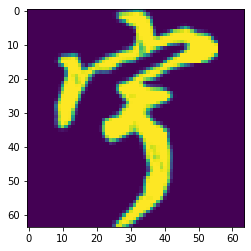

In [93]:
# we'll need to read the images in to transform them
#read the first listed image in the first folder and display it
img = mping.imread('kkanji2/U+5B87/72d56fcb33d10fe0.png')
plt.imshow(img)
plt.show()
# note that this image in only "first" as listed from the tar arcive above
# it is not "first" in terms of the codepoint listing we created directly above

In [94]:
# create a pandas dataframe that contains the codepoint for each image, 
# and its full path in the os and display that dataframe

#  ** reminder:  makes sure to set the path line correctly using the fact that
# the directory kkanji2 is in the same directory as the file codepoints.csv

data = []
dir = os.path.realpath('/home/wsuser/work/kkanji2')
for r, d, f in os.walk(dir):
    for file in f:
        if ".png" in file:
            data.append((r.split('/')[-1],os.path.join(r,file)))
df_kanji2 = pd.DataFrame(data, columns=['codepoint', 'image_file_path']).sort_values(by=['codepoint'], ignore_index = True)

In [95]:
# add a blank column to the dataframe with column name 'np_array'

df_kanji2['np_array'] = ""
df_kanji2

,codepoint,image_file_path,np_array
0,U+241C6,/home/wsuser/work/kkanji2/U+241C6/c0d603c6ce4a...,
1,U+241C6,/home/wsuser/work/kkanji2/U+241C6/689fa55040ec...,
2,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/4190e728bfc9...,
3,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/80582798ed70...,
4,U+25DA1,/home/wsuser/work/kkanji2/U+25DA1/512d7fcacddd...,
...,...,...,...
140419,U+FA55,/home/wsuser/work/kkanji2/U+FA55/093ab4bc62fab...,
140420,U+FA55,/home/wsuser/work/kkanji2/U+FA55/f03dee341d017...,
140421,U+FA55,/home/wsuser/work/kkanji2/U+FA55/e837b009ba51d...,
140422,U+FA5C,/home/wsuser/work/kkanji2/U+FA5C/15e2060396eba...,


In [96]:
# convert the pandas dataframe into a pyspark dataframe
df_kanji2_pyspk = spark.createDataFrame(df_kanji2)

In [97]:
# our data has 3,831 different classes each with unique string names
# which is based on their character codepoints
# but we want simple numeric class index
# so we instantiate a StringIndexer in spark:

indexer = StringIndexer(inputCol="codepoint",outputCol="classIndex")
indexed_df = indexer.fit(df_kanji2_pyspk).transform(df_kanji2_pyspk)
indexed_df.show()

+---------+--------------------+--------+----------+
|codepoint|     image_file_path|np_array|classIndex|
+---------+--------------------+--------+----------+
|  U+241C6|/home/wsuser/work...|        |    2606.0|
|  U+241C6|/home/wsuser/work...|        |    2606.0|
|  U+24FA3|/home/wsuser/work...|        |    2607.0|
|  U+24FA3|/home/wsuser/work...|        |    2607.0|
|  U+25DA1|/home/wsuser/work...|        |    3017.0|
|  U+27752|/home/wsuser/work...|        |    1966.0|
|  U+27752|/home/wsuser/work...|        |    1966.0|
|  U+27752|/home/wsuser/work...|        |    1966.0|
|  U+27752|/home/wsuser/work...|        |    1966.0|
|  U+27752|/home/wsuser/work...|        |    1966.0|
|  U+29780|/home/wsuser/work...|        |    3018.0|
|  U+29DDA|/home/wsuser/work...|        |    3019.0|
|  U+29E75|/home/wsuser/work...|        |    3020.0|
|   U+4093|/home/wsuser/work...|        |    3021.0|
|   U+4453|/home/wsuser/work...|        |     680.0|
|   U+4453|/home/wsuser/work...|        |     

In [98]:
# transform back to pandas dataframe:
df_kanji2 = indexed_df.toPandas()
df_kanji2

,codepoint,image_file_path,np_array,classIndex
0,U+241C6,/home/wsuser/work/kkanji2/U+241C6/c0d603c6ce4a...,,2606.0
1,U+241C6,/home/wsuser/work/kkanji2/U+241C6/689fa55040ec...,,2606.0
2,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/4190e728bfc9...,,2607.0
3,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/80582798ed70...,,2607.0
4,U+25DA1,/home/wsuser/work/kkanji2/U+25DA1/512d7fcacddd...,,3017.0
...,...,...,...,...
140419,U+FA55,/home/wsuser/work/kkanji2/U+FA55/093ab4bc62fab...,,1041.0
140420,U+FA55,/home/wsuser/work/kkanji2/U+FA55/f03dee341d017...,,1041.0
140421,U+FA55,/home/wsuser/work/kkanji2/U+FA55/e837b009ba51d...,,1041.0
140422,U+FA5C,/home/wsuser/work/kkanji2/U+FA5C/15e2060396eba...,,3016.0


In [99]:
# add a column containing and numpy array of the image indicated in the path in image_file_path
# and at the same time, flatten each image from a 64 x 64 numpy array to a single
# dimension 4096 element long numpy array
df_kanji2['np_array'] = df_kanji2['image_file_path'].apply(lambda x: np.asarray(Image.open(x))).apply(lambda y: np.reshape(y,(4096,)))

In [100]:
df_kanji2

,codepoint,image_file_path,np_array,classIndex
0,U+241C6,/home/wsuser/work/kkanji2/U+241C6/c0d603c6ce4a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2606.0
1,U+241C6,/home/wsuser/work/kkanji2/U+241C6/689fa55040ec...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2606.0
2,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/4190e728bfc9...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2607.0
3,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/80582798ed70...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2607.0
4,U+25DA1,/home/wsuser/work/kkanji2/U+25DA1/512d7fcacddd...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3017.0
...,...,...,...,...
140419,U+FA55,/home/wsuser/work/kkanji2/U+FA55/093ab4bc62fab...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1041.0
140420,U+FA55,/home/wsuser/work/kkanji2/U+FA55/f03dee341d017...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1041.0
140421,U+FA55,/home/wsuser/work/kkanji2/U+FA55/e837b009ba51d...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1041.0
140422,U+FA5C,/home/wsuser/work/kkanji2/U+FA5C/15e2060396eba...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3016.0


In [101]:
# take the np_array and classIndex columns out of the dataframe and put them into two numpy arrays
images_kanji = df_kanji2["np_array"].to_numpy()
labels_kanji = df_kanji2["classIndex"].to_numpy()

In [102]:
# at this point, the images are stored in a numpy array containing numpy arrays for each each, but instead
# we want a two dimensional numpy array, so convert that as follows
images_kanji = np.stack(images_kanji)

In [103]:
images_kanji.shape

(140424, 4096)

In [104]:
labels_kanji.shape

(140424,)

In [105]:
# now that the image and label arrays have the right dimensions, 
# we need to divide them into training, validation, and test sets:

x_train_kanji, x_test_kanji, y_train_kanji, y_test_kanji = train_test_split(images_kanji, labels_kanji, test_size = 0.2, random_state=42)
x_train_kanji, x_val_kanji, y_train_kanji, y_val_kanji = train_test_split(x_train_kanji, y_train_kanji, test_size = 0.2, random_state=28)

In [106]:
# we need to normalize each of the training and test image numpy arrays so that each number in the numpy
# array is between 0 and 1:

x_train_kanji =  x_train_kanji / 255
x_test_kanji = x_test_kanji / 255
x_val_kanji = x_val_kanji / 255

In [107]:
# model_1_2_k def

model_1_2_k = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),    
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),    
    tf.keras.layers.Dense(3832, activation=tf.nn.softmax)
])

In [108]:
# model_1_2_k compile
model_1_2_k.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [109]:
# model_1_2_k fit
model_1_2_k.fit(x_train_kanji, y_train_kanji, epochs=20, verbose=1, validation_data=(x_val_kanji, y_val_kanji))

Epoch 1/20
2809/2809 [==============================] - 26s 9ms/step - loss: 5.4430 - accuracy: 0.1814 - val_loss: 3.8729 - val_accuracy: 0.3508
Epoch 2/20
2809/2809 [==============================] - 25s 9ms/step - loss: 3.3847 - accuracy: 0.3924 - val_loss: 3.4035 - val_accuracy: 0.4237
Epoch 3/20
2809/2809 [==============================] - 25s 9ms/step - loss: 2.7520 - accuracy: 0.4693 - val_loss: 3.3251 - val_accuracy: 0.4562
Epoch 4/20
2809/2809 [==============================] - 26s 9ms/step - loss: 2.3661 - accuracy: 0.5229 - val_loss: 3.2626 - val_accuracy: 0.4744
Epoch 5/20
2809/2809 [==============================] - 25s 9ms/step - loss: 2.1251 - accuracy: 0.5528 - val_loss: 3.2481 - val_accuracy: 0.4820
Epoch 6/20
2809/2809 [==============================] - 25s 9ms/step - loss: 1.9293 - accuracy: 0.5812 - val_loss: 3.3912 - val_accuracy: 0.4891
Epoch 7/20
2809/2809 [==============================] - 25s 9ms/step - loss: 1.7918 - accuracy: 0.6028 - val_loss: 3.4771 - val_ac

In [110]:
score = model_1_2_k.evaluate(x_test_kanji, y_test_kanji, verbose=0)
print('model_1_2_k test loss:', score[0])
print('model_1_2_k test accuracy', score[1])

model_1_2_k test loss: 4.8285813331604
model_1_2_k test accuracy 0.49211323261260986


In [111]:
# model_2_k def

batch_size = 128
num_classes = 3832       #  here we specify the number of classes as 3832 instead of 10
epochs = 12

# input image dimensions
img_rows, img_cols = 64, 64

In [112]:
x_train = x_train_kanji
x_test = x_val_kanji
y_train = y_train_kanji
y_test = y_val_kanji

In [113]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [114]:
model_2_k = tf.keras.Sequential()
model_2_k.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_k.add(Conv2D(128, (3, 3), activation='relu'))
model_2_k.add(MaxPooling2D(pool_size=(2, 2)))
model_2_k.add(Dropout(0.25))
model_2_k.add(tf.keras.layers.Flatten())
model_2_k.add(tf.keras.layers.Dense(256, activation='relu'))
model_2_k.add(Dropout(0.5))
model_2_k.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [115]:
# model_2 compile

model_2_k.compile(optimizer='adam', 
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

In [116]:
# fit model_2_k

model_2_k.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_data=(x_test, y_test))

Epoch 1/12
703/703 [==============================] - 148s 182ms/step - loss: 5.6605 - accuracy: 0.1998 - val_loss: 3.2154 - val_accuracy: 0.5117
Epoch 2/12
703/703 [==============================] - 98s 139ms/step - loss: 3.2156 - accuracy: 0.4659 - val_loss: 2.3920 - val_accuracy: 0.6219
Epoch 3/12
703/703 [==============================] - 98s 139ms/step - loss: 2.3398 - accuracy: 0.5682 - val_loss: 1.9916 - val_accuracy: 0.6784
Epoch 4/12
703/703 [==============================] - 98s 139ms/step - loss: 1.8214 - accuracy: 0.6344 - val_loss: 1.8038 - val_accuracy: 0.7029
Epoch 5/12
703/703 [==============================] - 98s 139ms/step - loss: 1.4584 - accuracy: 0.6835 - val_loss: 1.7308 - val_accuracy: 0.7181
Epoch 6/12
703/703 [==============================] - 98s 139ms/step - loss: 1.1592 - accuracy: 0.7294 - val_loss: 1.7409 - val_accuracy: 0.7262
Epoch 7/12
703/703 [==============================] - 98s 139ms/step - loss: 0.9564 - accuracy: 0.7629 - val_loss: 1.7245 - val_a

In [117]:
score = model_2_k.evaluate(x_test_kanji, y_test_kanji, verbose=0)
print('model_2_k test loss:', score[0])
print('model_2_k test accuracy', score[1])

ValueError: in user code:

    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1183 test_step
        y_pred = self(x, training=False)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/envs/Python-3.7-CUDA/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_19 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 4096)
